In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import matplotlib.image as mpimg 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report

## Data Importierung

In [2]:
import os 
from glob import glob 
print(os.listdir("../data/processed/val"))
path_train =  '../data/processed/train/'
path_test = '../data/processed/test/'
path_val= '../data/processed/val/'


['NORMAL', 'PNEUMONIA']


## Data Aufarbeitung

In [3]:
path_train_pneumonia =  '../data/processed/train/PNEUMONIA'
path_train_normal = '../data/processed/train/NORMAL'
path_test_normal = '../data/processed/test/NORMAL'
path_test_pneumonia = '../data/processed/test/PNEUMONIA'
path_val_normal =  '../data/processed/val/NORMAL'
path_val_pneumonia =  '../data/processed/val/PNEUMONIA'

In [4]:
images_path = glob(path_train_normal+"/*.jpeg")
images = []
for  path in images_path:    
     images.append((path,0))
Pneumonia_images_path =  glob(path_train_pneumonia+"/*.jpeg")
for path in Pneumonia_images_path:
    images.append((path,1))


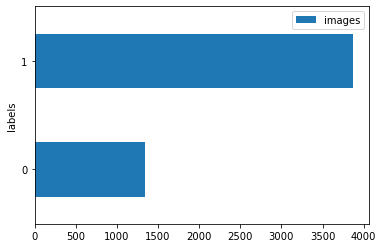

In [5]:
df = pd.DataFrame(images, columns=['images','labels'])
df.groupby('labels').count().plot.barh()

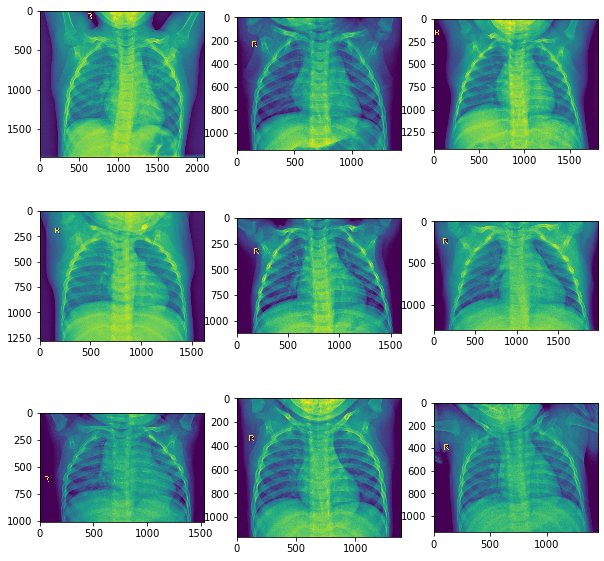

In [6]:
plt.figure(figsize=(10,10))
im = []
for i in range(0,10):
    im.append(plt.imread(df.loc[i].images))
len(im)
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.imshow(im[i])


## Probleme:

    - Data nicht balanciert bzw nicht genug images  mit 0 als Label.
    - Die images haben nicht die gleiche Größe.
    
## Lösung:
    - Data-Augmentation verwenden.
    - die größe der images ändern.

In [1]:
IMG_SIZE = 150 #auf Speicher Gründe muss die Bildgröße wie klein wie möglich sein
BATCH_SIZE = 32

Im medizinischen Bereich ist es üblich, dass die Daten unausgewogen sind, deshalb brauchen wir hier eine Data Augmentation.

## Data augmentation

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


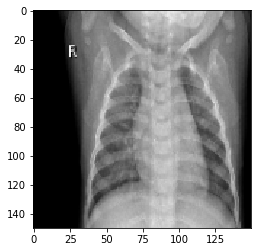

In [8]:

img_generator =keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                            rotation_range=10,
                                                            shear_range=0.2,
                                                            zoom_range=0.2,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            horizontal_flip=True)



train_generator = img_generator.flow_from_directory(path_train,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  #color_mode="grayscale",
                                                  shuffle=True,
                                                  class_mode='binary', 
                                                  subset='training')

val_generator  = img_generator.flow_from_directory(path_val,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  #batch_size= BATCH_SIZE,
                                                  #color_mode="grayscale",
                                                  shuffle=False,
                                                  class_mode='binary',
                                                  )

test_generator = img_generator.flow_from_directory(path_test,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  #color_mode="grayscale",
                                                  shuffle=False,
                                                  class_mode='binary')
plt.imshow(train_generator[0][0][0])

# Convolutional neural network

<img src="Image.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     
<p>ConvLayers haben die Aufgabe, die Merkmale der Bilder zu extrahieren, und die Fully Connected Layers sind für die Klassifikation zuständig.</p>

## MaxPooling

<img src="Max_pooling.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     
<p> Die Max-Pooling nimmt von jeder Sub-Region der Feature-Map die größte Anzahl.</p>

## Building a CNN Model

In [9]:
# sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
# layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001) #0.00001 reduce the learning rate when the metrics isnt improoving
#early_stopping = EarlyStopping(patience = 5)
callback = [learning_rate_reduction]
cnn_model =  Sequential()


In [11]:
cnn_model.add(Conv2D(32,(3,3), activation ='relu', input_shape=(IMG_SIZE , IMG_SIZE,3)))#Convlayer mit 32 Filtern der Größe 3x3. 
cnn_model.add(Conv2D(64, (3,3),activation='relu')) #increase the non-linearity
cnn_model.add(MaxPooling2D(2,2)) #die features-Maps werden als 2x2 array transformiert
#cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))


cnn_model.add(Flatten())#Matrizendaten abflachen, weil die Fully-Connected layer die Daten als Vector nimmt.
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

In [12]:
model = cnn_model.fit_generator(train_generator,
                                steps_per_epoch = 163,
                                epochs = 100,
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                callbacks = callback)

Epoch 1/100
163/163 [==============================] - 94s 576ms/step - loss: 0.4775 - accuracy: 0.7839 - val_loss: 1.1393 - val_accuracy: 0.8125
Epoch 2/100
163/163 [==============================] - 100s 615ms/step - loss: 0.2846 - accuracy: 0.8794 - val_loss: 0.8515 - val_accuracy: 0.6875
Epoch 3/100
162/163 [============================>.] - ETA: 0s - loss: 0.2333 - accuracy: 0.9062
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 [==============================] - 107s 659ms/step - loss: 0.2356 - accuracy: 0.9061 - val_loss: 2.7545 - val_accuracy: 0.5625
Epoch 4/100
163/163 [==============================] - 116s 713ms/step - loss: 0.2038 - accuracy: 0.9158 - val_loss: 0.8403 - val_accuracy: 0.6875
Epoch 5/100
162/163 [============================>.] - ETA: 0s - loss: 0.1844 - accuracy: 0.9273
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
163/163 [==============================] - 117s 717ms/step - loss: 0.18

163/163 [==============================] - 111s 682ms/step - loss: 0.0947 - accuracy: 0.9632 - val_loss: 0.5332 - val_accuracy: 0.6250
Epoch 53/100
163/163 [==============================] - 124s 763ms/step - loss: 0.0914 - accuracy: 0.9657 - val_loss: 0.4612 - val_accuracy: 0.7500
Epoch 54/100
163/163 [==============================] - 122s 751ms/step - loss: 0.1000 - accuracy: 0.9632 - val_loss: 1.2910 - val_accuracy: 0.6875
Epoch 55/100
163/163 [==============================] - 128s 784ms/step - loss: 0.0892 - accuracy: 0.9638 - val_loss: 0.3264 - val_accuracy: 0.8750
Epoch 56/100
163/163 [==============================] - 132s 809ms/step - loss: 0.0909 - accuracy: 0.9657 - val_loss: 0.6443 - val_accuracy: 0.7500
Epoch 57/100
163/163 [==============================] - 132s 812ms/step - loss: 0.0878 - accuracy: 0.9657 - val_loss: 1.0489 - val_accuracy: 0.6875
Epoch 58/100
163/163 [==============================] - 119s 729ms/step - loss: 0.0913 - accuracy: 0.9655 - val_loss: 0.6141 

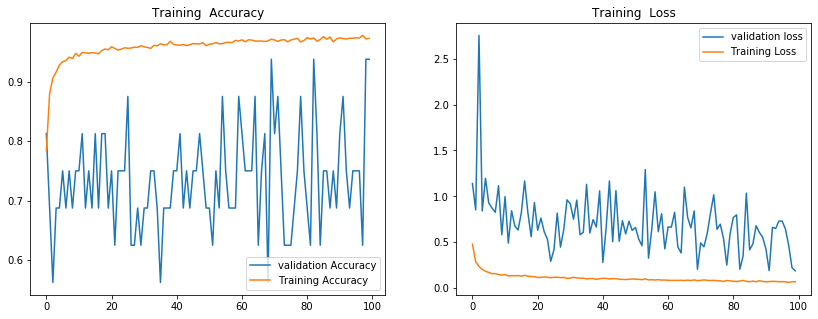

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history['val_accuracy'],label='validation Accuracy')
plt.plot(model.history['accuracy'], label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training  Accuracy')

plt.subplot(1, 2, 2)
plt.plot(model.history['val_loss'],label='validation loss')
plt.plot(model.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training  Loss')

plt.show()

##  Model evaluation

In [14]:
predic= cnn_model.evaluate(test_generator)
predictions =  cnn_model.predict_generator(test_generator)


20/20 [==============================] - 11s 551ms/step - loss: 0.7254 - accuracy: 0.8301


## Classification report

In [15]:
CNN_prediction_final = np.where(predictions>0.5,1,0)
print(classification_report(test_generator.classes,CNN_prediction_final , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.96      0.61      0.74       234
   Normal (Class 0)       0.81      0.98      0.89       390

           accuracy                           0.84       624
          macro avg       0.88      0.80      0.82       624
       weighted avg       0.86      0.84      0.83       624



## Confusion Matrix

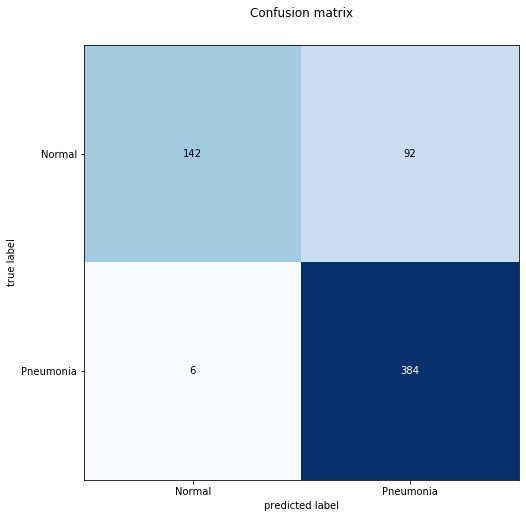

In [16]:
# Get the confusion matrix
CM = confusion_matrix(test_generator.classes, CNN_prediction_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

## ROC CNN

AUC Score: 0.9488658777120316


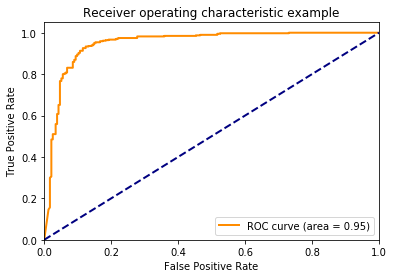

In [23]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( test_generator.classes , predictions)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Feature extractor

In [25]:
model_feat = tf.keras.Model(inputs=cnn_model.input,outputs=cnn_model.get_layer('dense_1').output)
feat_train = model_feat.predict_generator(train_generator)
feat_test = model_feat.predict_generator(test_generator)


In [26]:
df = pd.DataFrame(feat_train)
df.shape

(5216, 1)

## SVM

In [27]:
from sklearn.svm import SVC
from sklearn import metrics
svm = SVC(kernel='sigmoid')
svm.fit(feat_train,train_generator.classes)
svmpredict = svm.predict(feat_test)
print(classification_report(test_generator.classes,svmpredict , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.81      0.77      0.79       234
   Normal (Class 0)       0.87      0.89      0.88       390

           accuracy                           0.85       624
          macro avg       0.84      0.83      0.83       624
       weighted avg       0.85      0.85      0.85       624



## ROC SVM

AUC Score: 0.8316239316239316


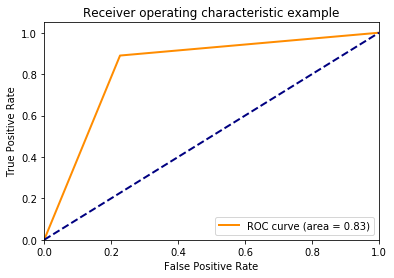

In [28]:
fpr , tpr , thresholds = roc_curve ( test_generator.classes ,svmpredict)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

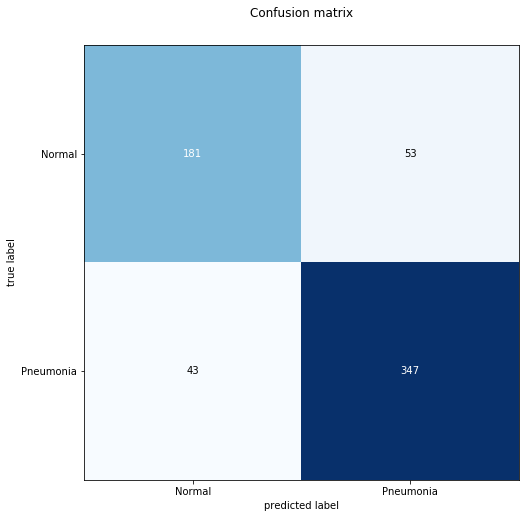

In [29]:
# Get the confusion matrix
svmCM = confusion_matrix(test_generator.classes, svmpredict)

fig, ax = plot_confusion_matrix(conf_mat=svmCM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

## K Nearest neighbour

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(feat_train,train_generator.classes)

knnpredict = knn.predict(feat_test)
print(classification_report(test_generator.classes,knnpredict , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))
knn.score(feat_test,test_generator.classes)

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.38      0.47      0.42       234
   Normal (Class 0)       0.63      0.54      0.58       390

           accuracy                           0.51       624
          macro avg       0.50      0.50      0.50       624
       weighted avg       0.54      0.51      0.52       624



0.5128205128205128

## ROC K Nearest neighbour

AUC Score: 0.5042735042735043


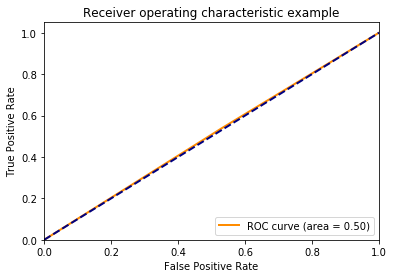

In [50]:
fpr , tpr , thresholds = roc_curve ( test_generator.classes ,knnpredict)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show() 

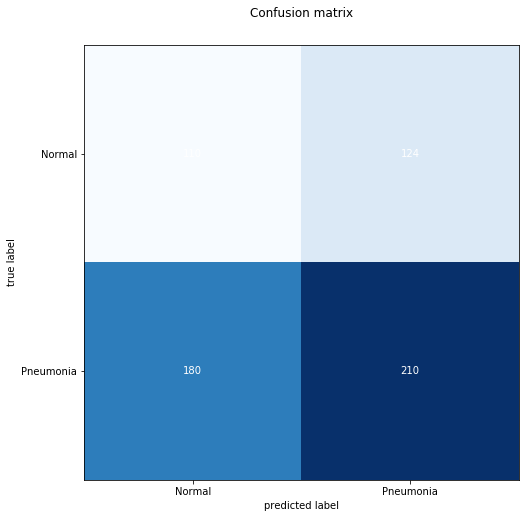

In [32]:
# Get the confusion matrix
knnCM = confusion_matrix(test_generator.classes, knnpredict)

fig, ax = plot_confusion_matrix(conf_mat=knnCM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

## Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(feat_train,train_generator.classes)

dtpredict = dt.predict(feat_test)
print(classification_report(test_generator.classes,dtpredict , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.54      0.26      0.35       234
   Normal (Class 0)       0.66      0.87      0.75       390

           accuracy                           0.64       624
          macro avg       0.60      0.56      0.55       624
       weighted avg       0.62      0.64      0.60       624



##  ROC Decision tree

AUC Score: 0.5628205128205128


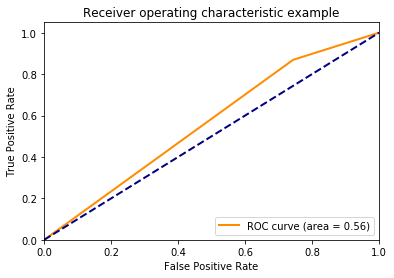

In [35]:
fpr , tpr , thresholds = roc_curve ( test_generator.classes ,dtpredict)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

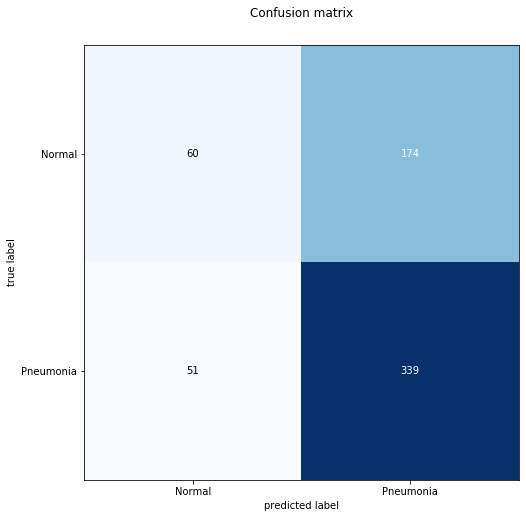

In [36]:
# Get the confusion matrix
dtCM = confusion_matrix(test_generator.classes, dtpredict)

fig, ax = plot_confusion_matrix(conf_mat=dtCM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

## Feed Forward NN

In [37]:
IMG_SIZ = 64 
BATCH_SIZ = 16

In [38]:
train_generator_ = img_generator.flow_from_directory(path_train,
                                                  target_size=(IMG_SIZ, IMG_SIZ),
                                                  batch_size=BATCH_SIZ,
                                                  color_mode="grayscale",
                                                  shuffle=True,
                                                  class_mode='binary', 
                                                  subset='training')

val_generator_  = img_generator.flow_from_directory(path_val,
                                                  target_size=(IMG_SIZ, IMG_SIZ),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  )

test_generator_ = img_generator.flow_from_directory(path_test,
                                                  target_size=(IMG_SIZ, IMG_SIZ),
                                                  color_mode="grayscale",
                                                  class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [39]:
cnn2_model = Sequential()
cnn2_model.add(Flatten(input_shape=(IMG_SIZ, IMG_SIZ,1)))
cnn2_model.add(Dense(512 ,activation='relu'))
cnn2_model.add(Dense(256, activation='relu'))
cnn2_model.add(Dense(1, activation='sigmoid'))


cnn2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,229,249
Trainable params: 2,229,249
Non-trainable params: 0
_________________________________________________________________


In [40]:
model = cnn2_model.fit_generator(train_generator_,
                                steps_per_epoch = 163,
                                epochs = 100,
                                validation_data=val_generator_,
                                callbacks = callback)

Epoch 1/100
163/163 [==============================] - 16s 100ms/step - loss: 0.6820 - accuracy: 0.7078 - val_loss: 0.7271 - val_accuracy: 0.5625
Epoch 2/100
163/163 [==============================] - 16s 99ms/step - loss: 0.4651 - accuracy: 0.7818 - val_loss: 0.8192 - val_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 17s 105ms/step - loss: 0.4260 - accuracy: 0.8083 - val_loss: 0.7647 - val_accuracy: 0.6250
Epoch 4/100
162/163 [============================>.] - ETA: 0s - loss: 0.4265 - accuracy: 0.8044
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 [==============================] - 18s 111ms/step - loss: 0.4258 - accuracy: 0.8052 - val_loss: 0.8714 - val_accuracy: 0.5625
Epoch 5/100
163/163 [==============================] - 17s 106ms/step - loss: 0.3519 - accuracy: 0.8612 - val_loss: 0.8025 - val_accuracy: 0.6250
Epoch 6/100
162/163 [============================>.] - ETA: 0s - loss: 0.3736 - accuracy: 0.8326
Epoch 000

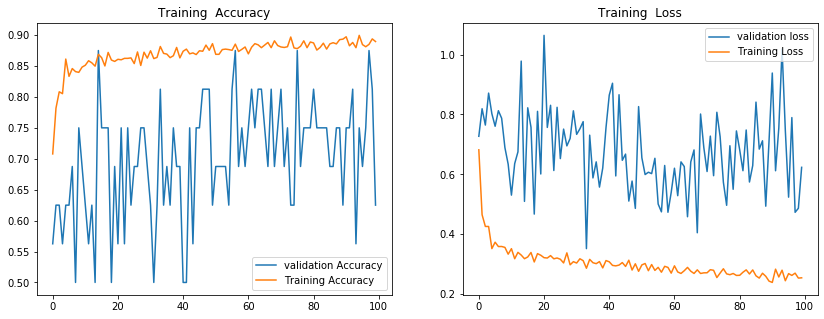

In [41]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history['val_accuracy'],label='validation Accuracy')
plt.plot(model.history['accuracy'], label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training  Accuracy')

plt.subplot(1, 2, 2)
plt.plot(model.history['val_loss'],label='validation loss')
plt.plot(model.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training  Loss')

plt.show()

In [42]:
# evaluate model
predic2= cnn2_model.evaluate(test_generator_)
predictions2 =  cnn2_model.predict_generator(test_generator_)
CNN_prediction_final_ = np.where(predictions2>0.5,1,0)
print(classification_report(test_generator_.classes,CNN_prediction_final_ , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

20/20 [==============================] - 3s 141ms/step - loss: 0.4615 - accuracy: 0.7917
                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.36      0.29      0.32       234
   Normal (Class 0)       0.62      0.70      0.66       390

           accuracy                           0.54       624
          macro avg       0.49      0.49      0.49       624
       weighted avg       0.52      0.54      0.53       624



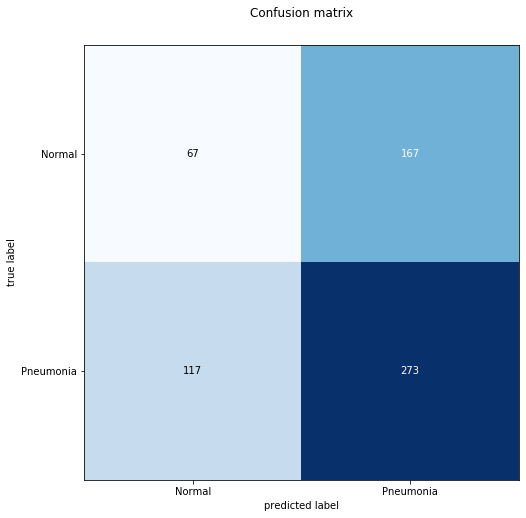

In [43]:
# Get the confusion matrix
CM2 = confusion_matrix(test_generator_.classes, CNN_prediction_final_)

fig, ax = plot_confusion_matrix(conf_mat=CM2 ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

## ROC Feed Forwad NN

AUC Score: 0.48797939951786107


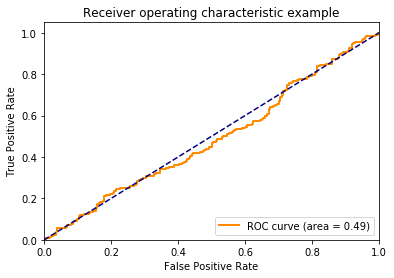

In [51]:
fpr , tpr , thresholds = roc_curve (test_generator.classes ,predictions2)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Activation layers Visualization


In [52]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in cnn_model.layers[:len(cnn_model.layers)]]

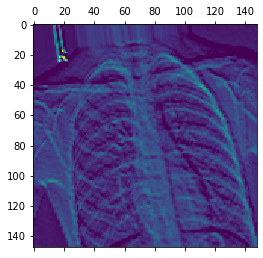

In [53]:
activation_model = Model(inputs=cnn_model.input, outputs=layer_outputs)
activations = activation_model.predict(test_generator[0])
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

C:\Users\nouam\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


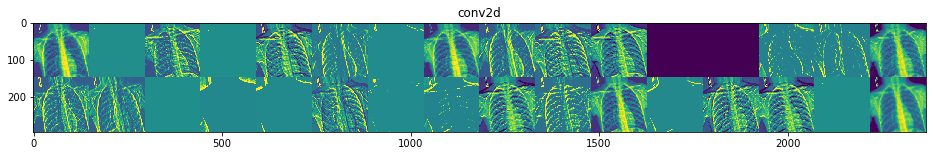

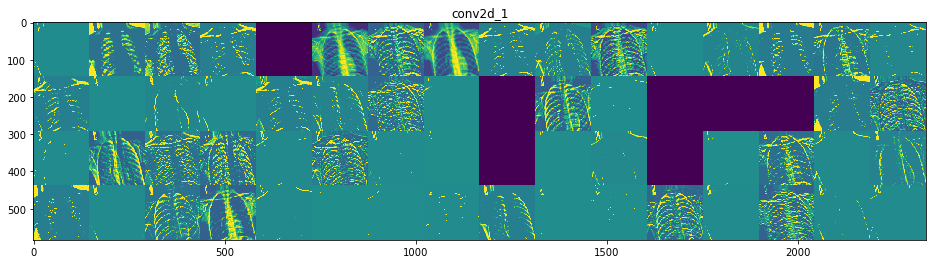

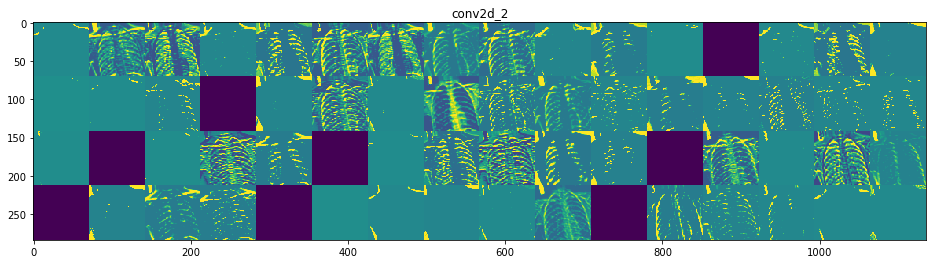

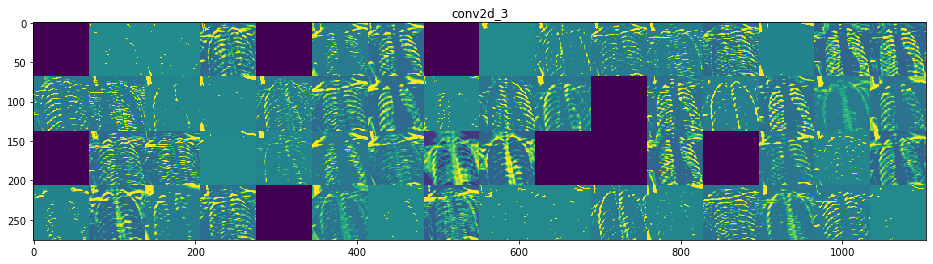

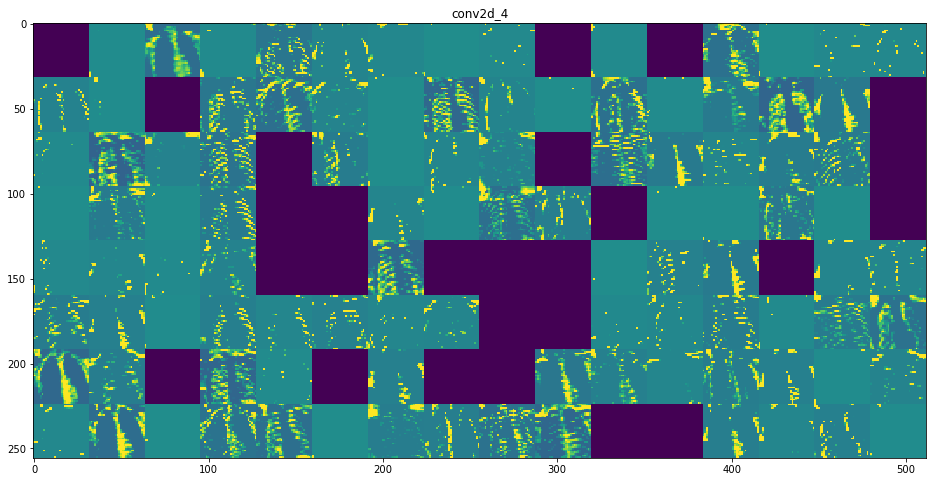

In [54]:
layer_names = []
for layer in cnn_model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
zipped_layers = zip(layer_names, activations)
for layer_name, layer_activation in zipped_layers: #this loop     
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

C:\Users\nouam\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


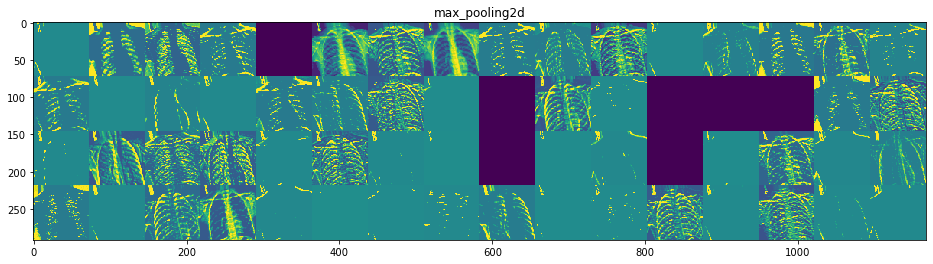

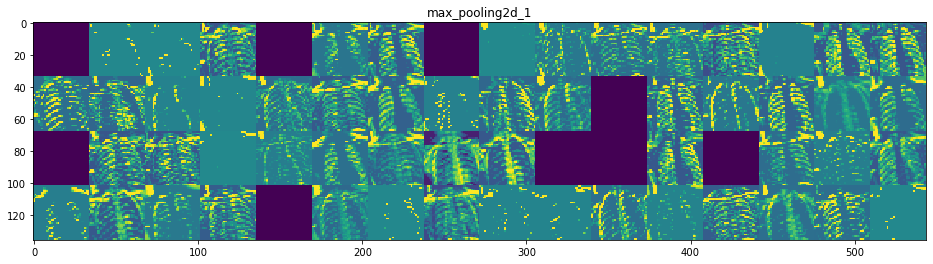

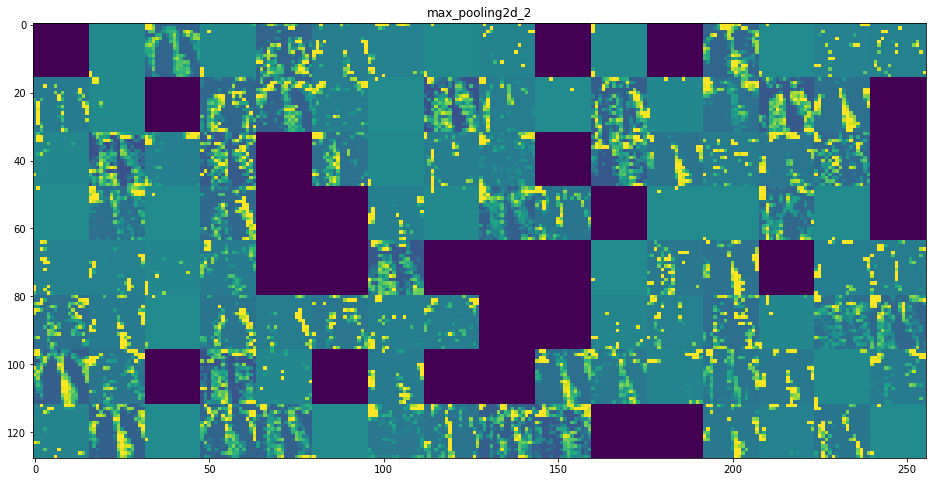

In [55]:
for layer in cnn_model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')